In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rlr_validate, train_neural_net, ttest_twomodels, mcnemar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Importing data

In [10]:
df = pd.read_csv('data.csv')
df = df.drop('row.names',axis=1)
df['famhist'] = df['famhist'].replace({'Present': 1, 'Absent': 0})
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


# Regression A

### 1)
Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.

In [11]:
target_variable = 'ldl'
features = df.drop(columns=[target_variable]).columns

# Prepare the feature matrix X and the target vector y
X = df[features]
y = df[target_variable].squeeze().values

# We have used one-of-K coding for feature transformation by substituting famhist = present or absent by 1 or 0, respectively

# Feature scaling so that each feature column has mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()

,sbp,tobacco,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,-0.295503,1.185854,-0.418470,-0.176786,3.277738,0.629336,1.373863
1,0.277089,-0.790237,0.412140,-0.843274,0.193344,0.671373,-0.612745,1.383115,1.373863
2,-0.992806,-0.774980,0.884332,1.185854,-0.112563,0.735519,-0.541183,0.218184,-0.727875
3,1.546985,0.842264,1.624141,1.185854,-0.214532,1.412621,0.295062,1.040488,1.373863
4,-0.211332,2.171805,0.305351,1.185854,0.703189,-0.012856,1.647775,0.423760,1.373863


### 2)

Introduce a regularization parameter λ as discussed in chapter 14 of the lecture
notes, and estimate the generalization error for different values of λ. Specifically, choose a reasonable range of values of λ (ideally one where the generalization error first drop and then increases), and for each value use K = 10 fold
cross-validation (algorithm 5) to estimate the generalization error.
Include a figure of the estimated generalization error as a function of λ in the
report and briefly discuss the result.

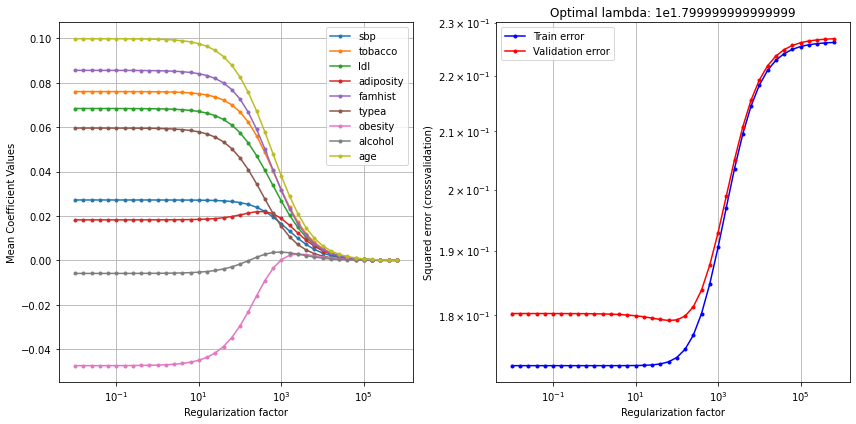

Regularized linear regression:
- Training error: 0.17339168206434796
Optimal lambda: 63.09573444801917
Weights:
         Offset          0.3463
            sbp          0.0268
        tobacco          0.0707
            ldl          0.0618
      adiposity          0.0195
        famhist          0.0777
          typea          0.0512
        obesity         -0.0356
        alcohol         -0.0031
            age          0.0889


In [17]:
X = X_scaled_df

# Attributes names:
attributeNames = X.columns.values.tolist()

# Compute values of N, M
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = [u'Offset'] + attributeNames
M = M + 1

K = 10

# --------------------Regression Part A ------------------#
# Values of lambda
lambdas = np.power(10.,np.arange(-2,6,0.2))

# Initialize variables
Error_train_rlr = np.empty((1,1))
w_rlr = np.empty((M,1))
mu = np.empty((1, M-1))
sigma = np.empty((1, M-1))

opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X, y, lambdas, K)

Xty = X.T @ y
XtX = X.T @ X

# Estimate weights for the optimal value of lambda, on entire training set
lambdaI = opt_lambda * np.eye(M)
lambdaI[0,0] = 0 # Do no regularize the bias term
w_rlr[:,0] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
# Compute mean squared error with regularization with optimal lambda
Error_train_rlr[0] = np.square(y-X @ w_rlr[:,0]).sum(axis=0)/y.shape[0]

# Display the results
plt.figure(1, figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
plt.xlabel('Regularization factor')
plt.ylabel('Mean Coefficient Values')
plt.legend(attributeNames[1:], loc='best')
plt.grid()

plt.subplot(1,2,2)
plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
plt.loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
plt.xlabel('Regularization factor')
plt.ylabel('Squared error (crossvalidation)')
plt.legend(['Train error','Validation error'])
plt.grid()

plt.tight_layout()
plt.show()

# Display results
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))

# Optimal lambda
print('Optimal lambda: {0}'.format(opt_lambda))

print('Weights:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,0],4)))
    

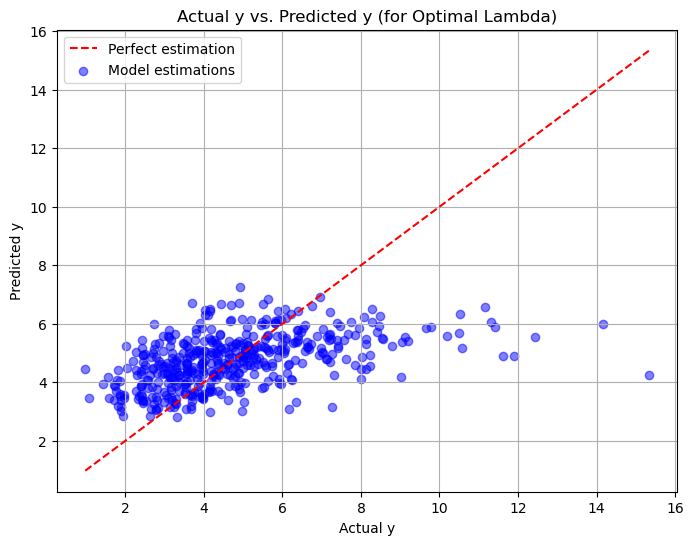

In [78]:
# Predict y_est
y_est = X @ w_rlr

# Plot y vs. y_est
plt.figure(figsize=(8, 6))
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='red', linestyle='--')
plt.scatter(y, y_est, c='blue', marker='o', alpha=0.5)
plt.title('Actual y vs. Predicted y (for Optimal Lambda)')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.legend(['Perfect estimation','Model estimations'])
plt.grid(True)
plt.show()


### 3)

Explain how the output, y, of the linear model with the lowest generalization
error (as determined in the previous question) is computed for a given input
x. What is the effect of an individual attribute in x on the output, y, of the
linear model? Does the effect of individual attributes make sense based on your
understanding of the problem?

# Regression B

In [79]:
def find_optimal_lambda(X_train, y_train, lambdas, train_index_inner, test_index_inner):
    X_train_inner = X_train[train_index_inner,:]
    y_train_inner = y_train[train_index_inner]
    X_test_inner = X_train[test_index_inner,:]
    y_test_inner = y_train[test_index_inner]

    XtX_inner = X_train_inner.T @ X_train_inner
    Xty_inner = X_train_inner.T @ y_train_inner   

    RLR_error = np.empty((len(lambdas)))
    w = np.empty((X_train_inner.shape[1],len(lambdas)))

    for l in range(0,len(lambdas)):
        # Compute parameters for current value of lambda and current CV fold
        # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
        lambdaI_inner = lambdas[l] * np.eye(M)
        lambdaI_inner[0,0] = 0 # remove bias regularization
        w[:,l] = np.linalg.solve(XtX_inner+lambdaI_inner,Xty_inner).squeeze()
        # Evaluate training and test performance
        RLR_error[l] = np.power(y_test_inner - X_test_inner @ w[:,l].T,2).mean(axis=0)

    return RLR_error


In [80]:
def find_optimal_hvalue(X_train, y_train, train_index_inner, test_index_inner, n_hidden_units, loss_fn, n_replicates, max_iter):
    X_train_inner_tensor = torch.Tensor(X_train[train_index_inner,:] )
    y_train_inner_tensor = torch.Tensor(y_train[train_index_inner] )
    X_test_inner_tensor = torch.Tensor(X_train[test_index_inner,:] )
    y_test_inner_tensor = torch.Tensor(y_train[test_index_inner] )

    y_train_inner_tensor = y_train_inner_tensor.unsqueeze(1)

    mse_ANN = np.empty((len(n_hidden_units)))

    for i, h_value in enumerate(n_hidden_units):
        print('Training model for h_value = {0}'.format(h_value))
        model = lambda: torch.nn.Sequential(
                            torch.nn.Linear(M, h_value), #M features to n_hidden_units
                            torch.nn.Tanh(),   # 1st transfer function,
                            torch.nn.Linear(h_value, 1), # n_hidden_units to 1 output neuron
                            # no final tranfer function, i.e. "linear output"
                            )
        #Train model  

        net, _, learning_curve = train_neural_net(model,
                                                loss_fn,
                                                X=X_train_inner_tensor,
                                                y=y_train_inner_tensor,
                                                n_replicates=n_replicates,
                                                max_iter=max_iter)
        
        # Determine estimated values for test set
        y_test_est = net(X_test_inner_tensor)
        
        # Determine squared errors and mean squared errors
        se = (y_test_est.float().detach().flatten()-y_test_inner_tensor.float().detach().flatten())**2 # squared error
        mse_ANN[i] = sum(se) / len(y_test_inner_tensor) #mean
        
        print('MSE for ANN model with h_value = {0} is {1}'.format(h_value, mse_ANN[i]))

    return mse_ANN


In [81]:
def eval_optimal_hvalue(X_train, y_train, X_test, y_test, loss_fn, n_replicates, max_iter, best_h_ANN):
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train)
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test)

    '''------------------ANN-------------------'''

    model = lambda: torch.nn.Sequential(
                        torch.nn.Linear(M, best_h_ANN), #M features to n_hidden_units
                        torch.nn.Tanh(),   # 1st transfer function,
                        torch.nn.Linear(best_h_ANN, 1), # n_hidden_units to 1 output neuron
                        # no final tranfer function, i.e. "linear output"
                        )
    # Train best model on training data
    y_train_tensor = y_train_tensor.unsqueeze(1)

    net, _, learning_curve = train_neural_net(model,
                                                    loss_fn,
                                                    X=X_train_tensor,
                                                    y=y_train_tensor,
                                                    n_replicates=n_replicates,
                                                    max_iter=max_iter)
    # Determine estimated class labels for test set
    ANN_y_test_est = net(X_test_tensor)
        
        # Determine errors and errors
    se = (ANN_y_test_est.float().flatten()-y_test_tensor.float().flatten())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test_tensor)).data.numpy() #mean

    return mse, ANN_y_test_est, learning_curve

Baseline test error: 3.376401542057489
################################1/100###################################

Crossvalidation fold: 1/10 outer 1/10 inner
Training model for h_value = 1

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	16.079117	0.0011458858
		2000	6.980706	0.0006325403
		Final loss:
		2000	6.980706	0.0006325403
MSE for ANN model with h_value = 1 is 7.47833776473999
Training model for h_value = 2

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	7.3920918	0.0010444276
		2000	4.026373	0.00023668246
		Final loss:
		2000	4.026373	0.00023668246
MSE for ANN model with h_value = 2 is 5.21523380279541
Training model for h_value = 4

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	3.3200219	0.0001581058
		2000	2.9824033	5.251898e-05
		Final loss:
		2000	2.9824033	5.251898e-05
MSE for ANN model with h_value = 4 is 4.170603275299072
Training model for h_value = 6

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	3.148382	0.00014295278
		2000	2.8464472	8.902901e-05
		Final loss:
		200

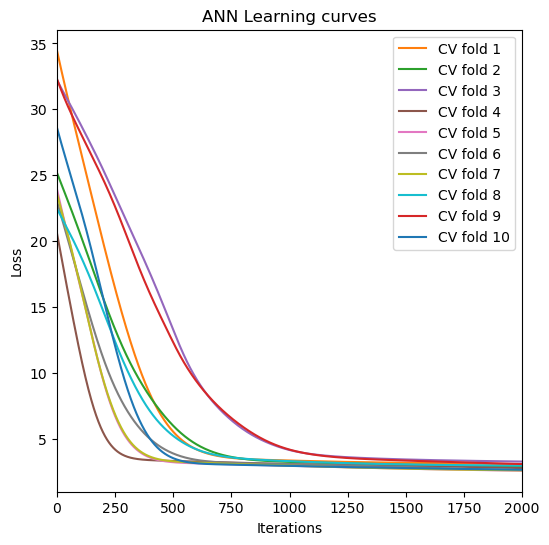

In [82]:
# Getting the dataset
target_variable = 'ldl'
features = df.drop(columns=[target_variable]).columns

# Prepare the feature matrix X and the target vector y
X = df[features]
y = df[target_variable].squeeze().values

# We have used one-of-K coding for feature transformation by substituting famhist = present or absent by 1 or 0, respectively

# Feature scaling so that each feature column has mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

X = X_scaled_df

# Attributes names:
attributeNames = X.columns.values.tolist()

# Compute values of N, M
N, M = X.shape


#--------------------Regression Part B ------------------#
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = [u'Offset'] + attributeNames
M = M + 1

K1 = 10
K2 = 10

CV1 = model_selection.KFold(K1, shuffle=True)
CV2 = model_selection.KFold(K2, shuffle=True)

# Base line test error
Error_test_baseline = np.empty((K1))

# Values of lambda
lambdas = np.power(10.,np.arange(-5,9,0.2))

# Initialize variables RLR
Error_train_rlr = np.empty((K1,1))
Error_test_rlr = np.empty((K1,1))
w_rlr = np.empty((M,K1))
best_lambda = [0] * K1

# Initialize variables for ANN
Errors_train_ANN = []
Errors_test_ANN = []
ANN_overall_error = np.empty(K1)
max_iter = 2000
n_replicates = 1
best_h_ANN = [0] * K1
#n_hidden_units = [1,2,4,6,8,10,15,20]
n_hidden_units = [1,2,4,6,8,10,12]

# Init loss function
loss_fn = torch.nn.MSELoss()

# Setup figure for display of learning curves and error rates in fold
learn_curve_plot = plt.figure(figsize=(6,6))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']# Make a list for storing assigned color of learning curve for up to K=10


# Predicted y values for each model
ANN_y_est = [0] * K1
RLR_y_est = [0] * K1
Baseline_y_est = [0] * K1

# True y values for each model
Outer_y_true = [0] * K1


k1 = 0
for train_index_outer, test_index_outer in CV1.split(X,y):

    X_train = X[train_index_outer,:]
    y_train = y[train_index_outer]
    X_test = X[test_index_outer,:]
    y_test = y[test_index_outer]

    XtX = X_train.T @ X_train
    Xty = X_train.T @ y_train

    # Baseline: use y train mean to predict y test
    y_train_mean = np.mean(y_train)
    Error_test_baseline[k1] = np.square(y_test - y_train_mean).sum(axis=0)/y_test.shape[0]
    print('Baseline test error: {0}'.format(Error_test_baseline[k1]))

    ANN_models_error = np.zeros((K2, len(n_hidden_units)))
    RLR_models_error = np.zeros((K2, len(lambdas)))

    k2 = 0
    for train_index_inner, test_index_inner in CV2.split(X_train,y_train):
        print(f'################################{int((k1)*K1+(k2+1))}/{int(K1*K2)}###################################')
        print('\nCrossvalidation fold: {0}/{1} outer {2}/{3} inner'.format(k1+1,K1,k2+1,K2)) 
        
        ### Find errors for all lambda values ###
        RLR_models_error[k2] = find_optimal_lambda(X_train, y_train, lambdas, train_index_inner, test_index_inner)

        ### Find errors for all h values ###
        ANN_models_error[k2] = find_optimal_hvalue(X_train, y_train, train_index_inner, test_index_inner, n_hidden_units, loss_fn, n_replicates, max_iter)

        k2 += 1

    # Find best lambda and h value for current outer fold by taking the mean of the inner folds for each lambda and h value
    best_lambda[k1] = lambdas[np.argmin(np.mean(RLR_models_error, axis=0))]
    best_h_ANN[k1] = n_hidden_units[np.argmin(np.mean(ANN_models_error, axis=0))]

    print('Best h value for ANN model is {0}'.format(best_h_ANN[k1]))
    print('Best lambda value for RLR model is {0}'.format(best_lambda[k1]))
    
    # Outer fold
    # eval_optimal_hvalue
    ANN_overall_error[k1], ANN_y_test_est, learning_curve = eval_optimal_hvalue(X_train, y_train, X_test, y_test, loss_fn, n_replicates, max_iter, best_h_ANN[k1])

    # Display the learning curve for the best net in the current fold
    h_curve, = plt.plot(learning_curve, color=color_list[k1])
    h_curve.set_label('CV fold {0}'.format(k1+1))
        
    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = best_lambda[k1] * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k1] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    
    # Compute mean squared error with regularization with optimal lambda
    Error_test_rlr[k1] = np.power(y_test - X_test @ w_rlr[:,k1].T,2).mean(axis=0)

    # Predict y values for each model
    ANN_y_est[k1] = ANN_y_test_est.detach().numpy().squeeze()
    RLR_y_est[k1] = X_test @ w_rlr[:,k1].T
    Baseline_y_est[k1] = y_train_mean * np.ones(y_test.shape[0])

    Outer_y_true[k1] = y_test

    k1 += 1

plt.xlabel('Iterations')
plt.xlim(0, max_iter)
plt.ylabel('Loss')
plt.legend()
plt.title('ANN Learning curves')

# best h and lambda for each outer fold
print('Best h value for ANN model is {0}'.format(best_h_ANN))
print('Best lambda value for RLR model is {0}'.format(best_lambda))

# make a table with folds, h and lambda and errors from a dataframe
resultsdf = pd.DataFrame({'Fold': np.arange(1, K1+1), 'h': best_h_ANN, 'ANN_error': ANN_overall_error, 'lambda': best_lambda, 'RLR_error': Error_test_rlr.flatten(), 'Baseline_error': Error_test_baseline.flatten()})
print(resultsdf)

In [85]:
print(resultsdf.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 Fold &  h &  ANN\_error &    lambda &  RLR\_error &  Baseline\_error \\
\midrule
    1 &  1 &   0.382979 & 39.810717 &   0.340426 &        0.361702 \\
    2 &  2 &   0.276596 & 15.848932 &   0.276596 &        0.446809 \\
    3 &  1 &   0.304348 & 25.118864 &   0.282609 &        0.369565 \\
    4 &  1 &   0.260870 & 25.118864 &   0.239130 &        0.195652 \\
    5 &  1 &   0.282609 & 25.118864 &   0.260870 &        0.413043 \\
    6 &  1 &   0.260870 & 25.118864 &   0.239130 &        0.369565 \\
    7 &  2 &   0.260870 &  0.000010 &   0.239130 &        0.326087 \\
    8 &  1 &   0.217391 & 15.848932 &   0.195652 &        0.195652 \\
    9 &  1 &   0.217391 & 15.848932 &   0.260870 &        0.347826 \\
   10 &  1 &   0.369565 & 25.118864 &   0.326087 &        0.434783 \\
\bottomrule
\end{tabular}



C:\Users\August-PC\AppData\Local\Temp\ipykernel_44160\2296612199.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(resultsdf.to_latex(index=False))


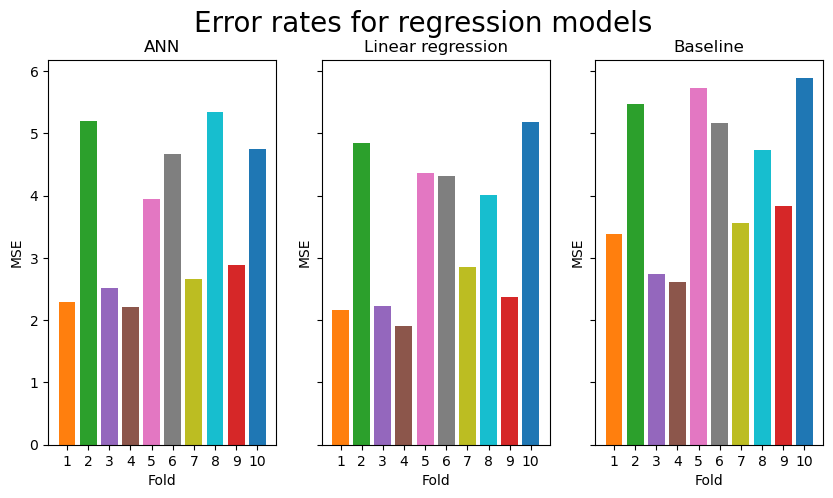

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(10,5),sharex=True, sharey=True)
errors_to_display = [ANN_overall_error, Error_test_rlr.flatten(), Error_test_baseline]
titels = ['ANN','Linear regression', 'Baseline']

for i in range(3):
    ax[i].bar(np.arange(1, K1+1), errors_to_display[i], color=color_list)
    ax[i].set_xlabel('Fold')
    ax[i].set_xticks(np.arange(1, K1+1))
    ax[i].set_ylabel('MSE')
    ax[i].set_title(titels[i])

plt.suptitle('Error rates for regression models', fontsize=20)
plt.show()

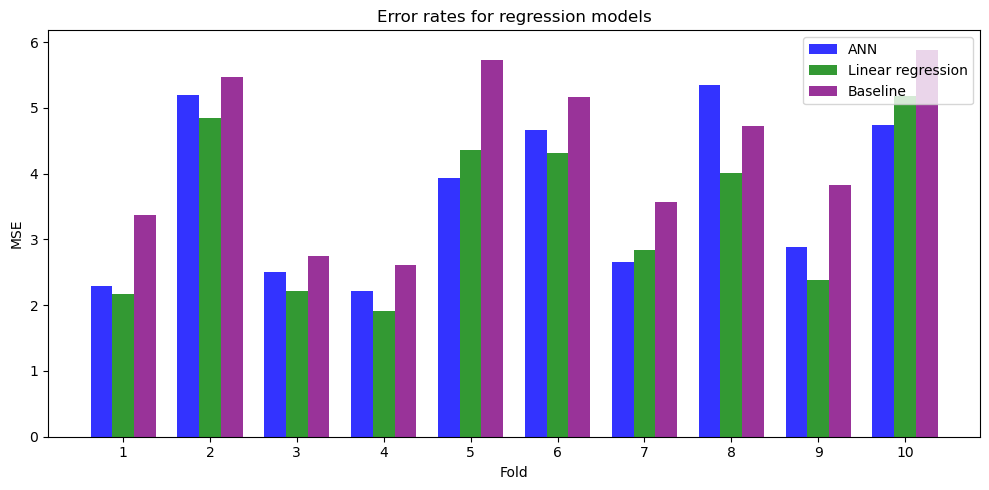

In [84]:
# plot hist of ANN, RLR and baseline together so there is 3 bars for each fold
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(K1)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, ANN_overall_error, bar_width, alpha=opacity, color='b',label='ANN')
rects2 = plt.bar(index + bar_width, Error_test_rlr.flatten(), bar_width, alpha=opacity, color='g',label='Linear regression')
rects3 = plt.bar(index + bar_width + bar_width, Error_test_baseline.flatten(), bar_width, alpha=opacity, color='purple',label='Baseline')

plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Error rates for regression models')
plt.xticks(index + bar_width, np.arange(1, K1+1))
plt.legend()

plt.tight_layout()
plt.show()


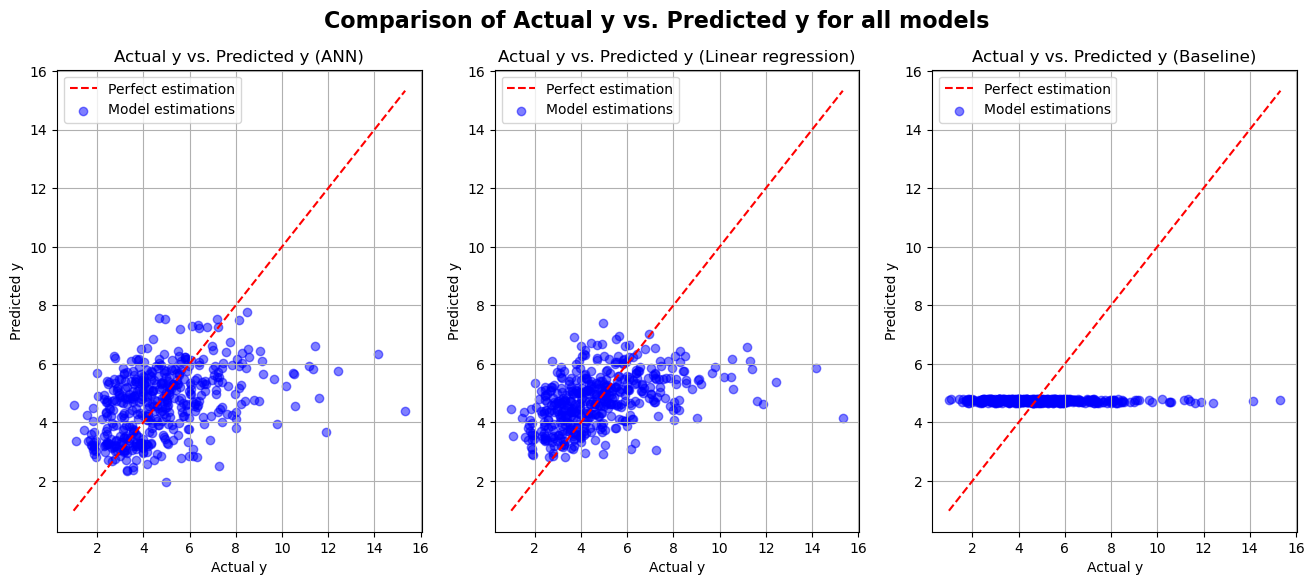

In [86]:
ANN_y_est_con = np.concatenate(ANN_y_est).ravel()
RLR_y_est_con = np.concatenate(RLR_y_est).ravel()
Baseline_y_est_con = np.concatenate(Baseline_y_est).ravel()

Outer_y_true_con = np.concatenate(Outer_y_true).ravel()

# Plot predicted y vs. actual y
plt.figure(figsize=(16, 6))

y_est_list = [ANN_y_est_con, RLR_y_est_con, Baseline_y_est_con]
true_list = [Outer_y_true_con, Outer_y_true_con, Outer_y_true_con]
titles = ['ANN', 'RLR', 'Baseline']


plt.suptitle('Comparison of Actual y vs. Predicted y for all models', fontsize=16, fontweight='bold')

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot([true_list[i].min(), true_list[i].max()], [true_list[i].min(), true_list[i].max()], c='red', linestyle='--')
    plt.scatter(true_list[i], y_est_list[i], c='blue', marker='o', alpha=0.5)
    plt.title('Actual y vs. Predicted y ({0})'.format(titels[i]))
    plt.legend(['Perfect estimation', 'Model estimations'])
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    plt.grid(True)

plt.show()

In [88]:
alpha = 0.05

#Model ANN vs linReg
[thetahat, CI, p] = ttest_twomodels(Outer_y_true_con, ANN_y_est_con, RLR_y_est_con, alpha=alpha,loss_norm_p=2)
print('ANN vs linReg:\n CI:',CI, '\n p-value:\n',p )

#Model ANN vs Baseline
[thetahat, CI, p] = ttest_twomodels(Outer_y_true_con, ANN_y_est_con, Baseline_y_est_con, alpha=alpha,loss_norm_p=2)
print('ANN vs bs:\n CI:',CI, '\n p-value:\n',p )

#Model Linreg vs Baseline
[thetahat, CI, p] = ttest_twomodels(Outer_y_true_con, RLR_y_est_con, Baseline_y_est_con, alpha=alpha,loss_norm_p=2)
print('linReg vs bs:\n CI:',CI, '\n p-value:\n',p )

print('Genelization errors:\n ANN: ',np.mean(ANN_overall_error),'\n RLR:',np.mean(Error_test_rlr),'\n Baseline:',np.mean(Error_test_baseline))

ANN vs linReg:
 CI: (0.010944521470298146, 0.43465002982497514) 
 p-value:
 0.0393255988930557
ANN vs bs:
 CI: (-1.0255759565592388, -0.3029653068389554) 
 p-value:
 0.0003360376716230152
linReg vs bs:
 CI: (-1.1848759948233898, -0.5892598198700778) 
 p-value:
 9.152029884929078e-09
Genelization errors:
 ANN:  3.6463462591171263 
 RLR: 3.4236278442457335 
 Baseline: 4.310566053989458


# Classification - Part C

In [5]:
def find_optimal_lambda_class(X_train, y_train, lambdas, train_index_inner, test_index_inner, ):
    X_train_inner = X_train[train_index_inner,:]
    y_train_inner = y_train[train_index_inner]
    X_test_inner = X_train[test_index_inner,:]
    y_test_inner = y_train[test_index_inner]

    logReg_models_error = np.zeros((len(lambdas)))

    for i, la in enumerate(lambdas):
        #Logistic regression model
        model_logReg = LogisticRegression(solver='lbfgs', multi_class='ovr', tol=1e-4, random_state=9, penalty='l2', C=1/la)
        model_logReg.fit(X_train_inner,y_train_inner)
        logReg_y_est_inner = model_logReg.predict(X_test_inner)
        logReg_models_error[i] = np.sum(logReg_y_est_inner != y_test_inner) / len(y_test_inner)

    return logReg_models_error

In [6]:
def find_optimal_hvalue_class(X_train, y_train, train_index_inner, test_index_inner, n_hidden_units, loss_fn, n_replicates, max_iter):
    X_train_inner_tensor = torch.Tensor(X_train[train_index_inner,:] )
    y_train_inner_tensor = torch.Tensor(y_train[train_index_inner] )
    X_test_inner_tensor = torch.Tensor(X_train[test_index_inner,:] )
    y_test_inner_tensor = torch.Tensor(y_train[test_index_inner] )

    y_train_inner_tensor = y_train_inner_tensor.unsqueeze(1)

    ANN_models_error = np.zeros((len(n_hidden_units)))

    for i, h_value in enumerate(n_hidden_units):
        print('Training model for h_value = {0}'.format(h_value))
        model = lambda: torch.nn.Sequential(
                            torch.nn.Linear(M, h_value), #M features to n_hidden_units
                            torch.nn.Tanh(),   # 1st transfer function,
                            torch.nn.Linear(h_value, 1), # n_hidden_units to 1 output neuron
                            torch.nn.Sigmoid() # final tranfer function
                            )
        #Train model  

        net, _, learning_curve = train_neural_net(model,
                                                loss_fn,
                                                X=X_train_inner_tensor,
                                                y=y_train_inner_tensor,
                                                n_replicates=n_replicates,
                                                max_iter=max_iter)
        
        # Determine estimated values for test set
        y_test_est = net(X_test_inner_tensor)
        
        # Determine errors and errors
        er = (y_test_est.detach().numpy().flatten() > 0.5) != y_test_inner_tensor.numpy().flatten()
        ANN_models_error[i] = np.sum(er) / len(y_test_inner_tensor)
        
        print('MSE for ANN model with h_value = {0} is {1}'.format(h_value, ANN_models_error[i]))

    return ANN_models_error

In [7]:
def eval_optimal_hvalue_class(X_train, y_train, X_test, y_test, loss_fn, n_replicates, max_iter, best_h_ANN):
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train)
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test)

    '''------------------ANN-------------------'''
    model = lambda: torch.nn.Sequential(
                        torch.nn.Linear(M, best_h_ANN), #M features to n_hidden_units
                        torch.nn.Tanh(),   # 1st transfer function,
                        torch.nn.Linear(best_h_ANN, 1), # n_hidden_units to 1 output neuron
                        torch.nn.Sigmoid() # final tranfer function
                        )
    # Train best model on training data
    y_train_tensor = y_train_tensor.unsqueeze(1)

    net, _, learning_curve = train_neural_net(model,
                                                    loss_fn,
                                                    X=X_train_tensor,
                                                    y=y_train_tensor,
                                                    n_replicates=n_replicates,
                                                    max_iter=max_iter)
    # Determine estimated class labels for test set
    ANN_y_test_est = net(X_test_tensor)
        
        # Determine errors and errors
    er = (ANN_y_test_est.detach().numpy().flatten() > 0.5) != y_test_tensor.numpy().flatten()
    ANN_y_test_est = ANN_y_test_est.detach().numpy().flatten()
    ANN_y_test_est[ANN_y_test_est > 0.5] = 1
    ANN_y_test_est[ANN_y_test_est <= 0.5] = 0
    ANN_models_error = np.sum(er) / len(y_test_tensor)

    return ANN_models_error, ANN_y_test_est, learning_curve

Baseline test error: 0.3617021276595745
################################1/100###################################

Crossvalidation fold: 1/10 outer 1/10 inner
Training model for h_value = 1

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.50139517	2.425044e-05
		2000	0.495573	5.7129914e-06
		3000	0.4937766	2.4142296e-06
		Final loss:
		3000	0.4937766	2.4142296e-06
MSE for ANN model with h_value = 1 is 0.3333333333333333
Training model for h_value = 2

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.49438134	5.485366e-05
		2000	0.48511952	1.8429544e-05
		3000	0.47186226	1.8378916e-05
		Final loss:
		3000	0.47186226	1.8378916e-05
MSE for ANN model with h_value = 2 is 0.35714285714285715
Training model for h_value = 3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.47927603	6.553549e-05
		2000	0.44230387	4.3525422e-05
		3000	0.42858067	2.2112357e-05
		Final loss:
		3000	0.42858067	2.2112357e-05
MSE for ANN model with h_value = 3 is 0.38095238095238093
Training model for h_value = 4

	R

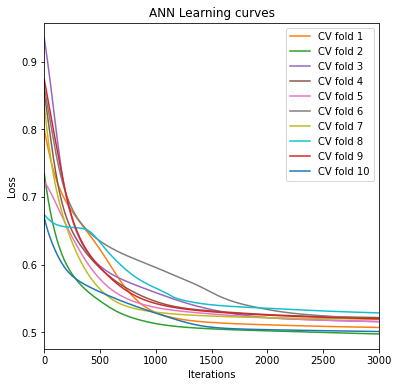

In [79]:
# Getting the dataset
target_variable = 'chd'
features = df.drop(columns=[target_variable]).columns

# Prepare the feature matrix X and the target vector y
X = df[features]
y = df[target_variable].squeeze().values

# We have used one-of-K coding for feature transformation by substituting famhist = present or absent by 1 or 0, respectively

# Feature scaling so that each feature column has mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

X = X_scaled_df
attributeNames = X.columns.values.tolist()
X = X.to_numpy()

# Attributes names:

# Compute values of N, M
N, M = X.shape


#--------------------Classification Part C ------------------#
K1 = 10
K2 = 10

CV1 = model_selection.KFold(K1, shuffle=True)
CV2 = model_selection.KFold(K2, shuffle=True)

# Base line test error
Error_test_baseline = np.empty((K1))

# Values of lambda
lambdas = np.power(10.,np.arange(-5,9,0.2))

# Initialize variables RLR
Error_train_rlr = np.empty((K1,1))
Error_test_rlr = np.empty((K1,1))
w_rlr = np.empty((M,K1))
best_lambda = [0] * K1

# Initialize variables for ANN
Errors_train_ANN = []
Errors_test_ANN = []
ANN_overall_error = np.empty(K1)
max_iter = 3000
n_replicates = 1
best_h_ANN = [0] * K1
#n_hidden_units = [1,2,4,6,8,10,15,20]
n_hidden_units = [1,2,3,4]

# Init loss function
loss_fn = torch.nn.BCELoss()

# Setup figure for display of learning curves and error rates in fold
learn_curve_plot = plt.figure(figsize=(6,6))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']# Make a list for storing assigned color of learning curve for up to K=10


# Predicted y values for each model
ANN_y_est = [0] * K1
RLR_y_est = [0] * K1
Baseline_y_est = [0] * K1

# True y values for each model
Outer_y_true = [0] * K1

k1 = 0
for train_index_outer, test_index_outer in CV1.split(X,y):
    X_train = X[train_index_outer,:]
    y_train = y[train_index_outer]
    X_test = X[test_index_outer,:]
    y_test = y[test_index_outer]

    XtX = X_train.T @ X_train
    Xty = X_train.T @ y_train

    # Baseline: use y train mean to predict y test using the largest class
    y_train_base_pred = np.argmax(np.bincount(y_train))
    # Error = Wrong predictions / Total predictions
    Error_test_baseline[k1] = (y_test != y_train_base_pred).sum(axis=0)/y_test.shape[0]
    print('Baseline test error: {0}'.format(Error_test_baseline[k1]))

    ANN_models_error = np.zeros((K2, len(n_hidden_units)))
    RLR_models_error = np.zeros((K2, len(lambdas)))

    k2 = 0
    for train_index_inner, test_index_inner in CV2.split(X_train,y_train):
        print(f'################################{int((k1)*K1+(k2+1))}/{int(K1*K2)}###################################')
        print('\nCrossvalidation fold: {0}/{1} outer {2}/{3} inner'.format(k1+1,K1,k2+1,K2)) 
        
        ### Find errors for all lambda values ###
        RLR_models_error[k2] = find_optimal_lambda_class(X_train, y_train, lambdas, train_index_inner, test_index_inner)

        ### Find errors for all h values ###
        ANN_models_error[k2] = find_optimal_hvalue_class(X_train, y_train, train_index_inner, test_index_inner, n_hidden_units, loss_fn, n_replicates, max_iter)

        k2 += 1

    # Find best lambda and h value for current outer fold by taking the mean of the inner folds for each lambda and h value
    best_lambda[k1] = lambdas[np.argmin(np.mean(RLR_models_error, axis=0))]
    best_h_ANN[k1] = n_hidden_units[np.argmin(np.mean(ANN_models_error, axis=0))]

    print('Best h value for ANN model is {0}'.format(best_h_ANN[k1]))
    print('Best lambda value for RLR model is {0}'.format(best_lambda[k1]))
    
    # Outer fold
    # eval_optimal_hvalue
    ANN_overall_error[k1], ANN_y_test_est, learning_curve = eval_optimal_hvalue_class(X_train, y_train, X_test, y_test, loss_fn, n_replicates, max_iter, best_h_ANN[k1])

    # Display the learning curve for the best net in the current fold
    h_curve, = plt.plot(learning_curve, color=color_list[k1])
    h_curve.set_label('CV fold {0}'.format(k1+1))
        
    # Logistic regression model
    model_logReg = LogisticRegression(penalty='l2', C=1/best_lambda[k1])
    model_logReg.fit(X_train,y_train)
    logReg_y_est = model_logReg.predict(X_test)
    Error_test_rlr[k1] = np.sum(logReg_y_est != y_test) / len(y_test)

    # Predict y values for each model
    ANN_y_est[k1] = ANN_y_test_est
    RLR_y_est[k1] = logReg_y_est
    Baseline_y_est[k1] = y_train_base_pred * np.ones(y_test.shape[0])

    Outer_y_true[k1] = y_test

    k1 += 1

plt.xlabel('Iterations')
plt.xlim(0, max_iter)
plt.ylabel('Loss')
plt.legend()
plt.title('ANN Learning curves')

# best h and lambda for each outer fold
print('Best h value for ANN model is {0}'.format(best_h_ANN))
print('Best lambda value for RLR model is {0}'.format(best_lambda))

# make a table with folds, h and lambda and errors from a dataframe
resultsdf = pd.DataFrame({'Fold': np.arange(1, K1+1), 'h': best_h_ANN, 'ANN_error': ANN_overall_error, 'lambda': best_lambda, 'RLR_error': Error_test_rlr.flatten(), 'Baseline_error': Error_test_baseline.flatten()})
print(resultsdf)

In [80]:
# multiply errors by 100 to get percentage
ANN_overall_error2 = np.round(ANN_overall_error * 100, 2)
Error_test_rlr2 = np.round(Error_test_rlr * 100, 2)
Error_test_baseline2 = np.round(Error_test_baseline * 100, 2)
best_lambda2 = np.round(best_lambda, 2) 

resultsdf2 = pd.DataFrame({'Fold': np.arange(1, K1+1), 'h': best_h_ANN, 'ANN_error': ANN_overall_error2, 'lambda': best_lambda2, 'RLR_error': Error_test_rlr2.flatten(), 'Baseline_error': Error_test_baseline2.flatten()})
print(resultsdf2.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 Fold &  h &  ANN\_error &  lambda &  RLR\_error &  Baseline\_error \\
\midrule
    1 &  1 &      38.30 &   39.81 &      34.04 &           36.17 \\
    2 &  2 &      27.66 &   15.85 &      27.66 &           44.68 \\
    3 &  1 &      30.43 &   25.12 &      28.26 &           36.96 \\
    4 &  1 &      26.09 &   25.12 &      23.91 &           19.57 \\
    5 &  1 &      28.26 &   25.12 &      26.09 &           41.30 \\
    6 &  1 &      26.09 &   25.12 &      23.91 &           36.96 \\
    7 &  2 &      26.09 &    0.00 &      23.91 &           32.61 \\
    8 &  1 &      21.74 &   15.85 &      19.57 &           19.57 \\
    9 &  1 &      21.74 &   15.85 &      26.09 &           34.78 \\
   10 &  1 &      36.96 &   25.12 &      32.61 &           43.48 \\
\bottomrule
\end{tabular}



C:\Users\August-PC\AppData\Local\Temp\ipykernel_44160\93119819.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(resultsdf2.to_latex(index=False))


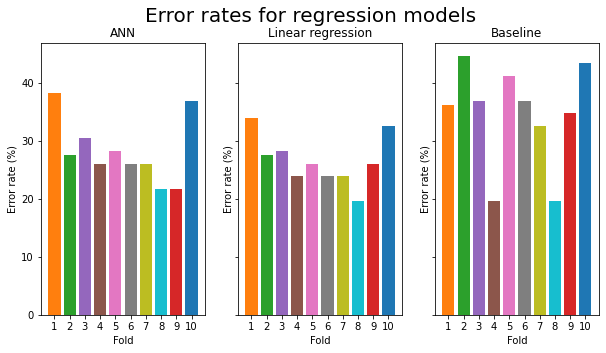

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(10,5),sharex=True, sharey=True)
errors_to_display = [ANN_overall_error, Error_test_rlr.flatten(), Error_test_baseline]
titels = ['ANN','Linear regression', 'Baseline']

for i in range(3):
    ax[i].bar(np.arange(1, K1+1), errors_to_display[i]*100, color=color_list)
    ax[i].set_xlabel('Fold')
    ax[i].set_xticks(np.arange(1, K1+1))
    ax[i].set_title(titels[i])
    ax[i].set_ylabel('Error rate (%)')

plt.suptitle('Error rates for regression models', fontsize=20)
plt.show()

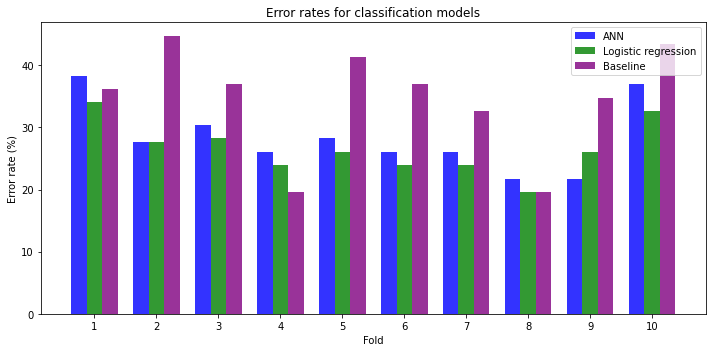

In [82]:
# plot hist of ANN, RLR and baseline together so there is 3 bars for each fold
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(K1)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, ANN_overall_error*100, bar_width, alpha=opacity, color='b',label='ANN')
rects2 = plt.bar(index + bar_width, Error_test_rlr.flatten()*100, bar_width, alpha=opacity, color='g',label='Logistic regression')
rects3 = plt.bar(index + bar_width + bar_width, Error_test_baseline.flatten()*100, bar_width, alpha=opacity, color='purple',label='Baseline')

plt.xlabel('Fold')
plt.ylabel('Error rate (%)')
plt.title('Error rates for classification models')
plt.xticks(index + bar_width, np.arange(1, K1+1))
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
# statistics
ANN_y_est_con = np.concatenate(ANN_y_est).ravel()
RLR_y_est_con = np.concatenate(RLR_y_est).ravel()
Baseline_y_est_con = np.concatenate(Baseline_y_est).ravel()

Outer_y_true_con = np.concatenate(Outer_y_true).ravel()

# mcNemar test
alpha = 0.05

#Model ANN vs logReg
[thetahat, CI, p] = mcnemar(Outer_y_true_con, ANN_y_est_con, RLR_y_est_con, alpha=alpha)
print("")

#Model ANN vs Baseline
[thetahat, CI, p] = mcnemar(Outer_y_true_con, ANN_y_est_con, Baseline_y_est_con, alpha=alpha)
print("")

#Model logReg vs Baseline
[thetahat, CI, p] = mcnemar(Outer_y_true_con, RLR_y_est_con, Baseline_y_est_con, alpha=alpha)
print("")


Result of McNemars test using alpha= 0.05
Comparison matrix n
[[324.   7.]
 [ 15. 116.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.0371264263328126, 0.0025010992178611247)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.13380050659179688

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[248.  83.]
 [ 54.  77.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (0.013430602423101456, 0.11195953929846003)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.016432262062014133

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[262.  77.]
 [ 40.  83.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (0.03475608256013163, 0.12525418454351045)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.0007995844433963236



In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05)

mdl = LogisticRegression(penalty='l2', C=1/25.12)

mdl.fit(X_train, y_train)

y_train_est = mdl.predict(X_train).T
y_test_est = mdl.predict(X_test).T

w_est = mdl.coef_[0] 

# print coeff with names
print(pd.DataFrame({'Attribute': attributeNames, 'Coefficient': w_est}))

   Attribute  Coefficient
0        sbp     0.086125
1    tobacco     0.317946
2        ldl     0.261338
3  adiposity     0.124477
4    famhist     0.344874
5      typea     0.229137
6    obesity    -0.129899
7    alcohol    -0.012751
8        age     0.472725
